In this Notebook we want to show that our model has a tight fit to the data ...

Try to _keep it simple_ for the paper. For actual detailed predictions, refer to the progress reports (published on Research Gate)

The first couple of paragraphs here are roughly copied from `models/utils.py`'s `initialize_COVID19_SEIQRD_spatial_rescaling` function

In [1]:
######################
## General packages ##
######################

import os
import sys
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
#################################
## Load visualization packages ##
#################################

from covid19_DTM.visualization.output import color_timeframes
from covid19_DTM.visualization.output import color_timeframes
from covid19_DTM.visualization.output import _apply_tick_locator 
from covid19_DTM.models.utils import output_to_visuals, add_negative_binomial

## Visualize weighted efficacies

In [49]:
age_classes=pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')

In [50]:
from covid19_DTM.models.TDPF import  make_vaccination_efficacy_function
df = make_vaccination_efficacy_function(update=False, agg='prov').df_efficacies
from covid19_DTM.models.TDPF import make_VOC_function
from covid19_DTM.data import model_parameters
VOC_params, vaccine_params = model_parameters.get_COVID19_SEIQRD_VOC_parameters(VOCs=['WT', 'abc', 'delta'])
VOC_function = make_VOC_function(VOC_params['logistic_growth'])

In [51]:
###########################
## Define desired format ##
###########################

# Define output dataframe
iterables=[]
for index_name in df.index.names:
    if index_name != 'VOC':
        iterables += [df.index.get_level_values(index_name).unique()]
index = pd.MultiIndex.from_product(iterables)
df_VOC_weighted = pd.DataFrame(index=index, columns=df.columns, dtype=float)

#######################################################
## Lexsorting warning due to index not being sorted? ##
#######################################################

df_VOC_weighted=df_VOC_weighted.sort_index()
df=df.sort_index()

########################
## Loop and aggregate ##
########################

# Computational loop
dates=df.index.get_level_values('date').unique()
NISs=df.index.get_level_values('NIS').unique()
age_classes=df.index.get_level_values('age').unique()
doses=df.index.get_level_values('dose').unique() 

with tqdm(total=len(dates)) as pbar:
    for date in dates:
        f_VOC = VOC_function(date,{},{})[0,:]
        for NIS in NISs:
            for age_class in age_classes:
                for dose in doses:
                    df_VOC_weighted.loc[(date, NIS, age_class, dose), 'e_s'] = np.sum(f_VOC * df.loc[(date, NIS, age_class, dose),'e_s'].values)
                    df_VOC_weighted.loc[(date, NIS, age_class, dose), 'e_i'] = (np.sum(f_VOC * df.loc[(date, NIS, age_class, dose),'e_i']))
                    df_VOC_weighted.loc[(date, NIS, age_class, dose), 'e_h'] = (np.sum(f_VOC * df.loc[(date, NIS, age_class, dose),'e_h']))
        pbar.update(1)

100%|███████████████████████████████████████████| 71/71 [01:35<00:00,  1.35s/it]


/tmp/ipykernel_134504/2230629199.py:53: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')


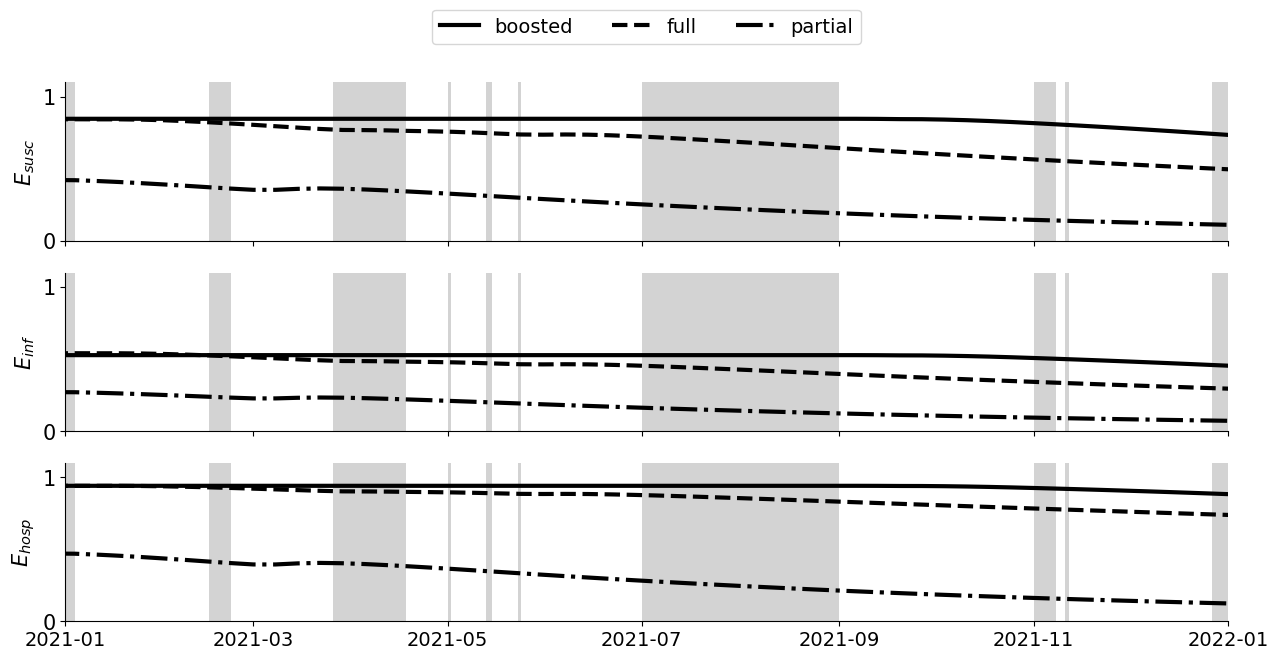

In [52]:
fig, axs = plt.subplots(3, 1, figsize=(15,7), sharex=True)

############################
## Vaccination parameters ##
############################

age_classes=df.index.get_level_values('age').unique()
ls=['-', '--', '-.']

idx=0
for dose in df.index.get_level_values('dose').unique():
    if dose != 'none':
        # Age group 85+
        axs[0].plot(df.index.get_level_values('date').unique(), df.loc[slice(None),slice(None),age_classes[-1],slice(None)].groupby(by=['date','dose']).mean().loc[(slice(None), dose), 'e_s'].values, linestyle=ls[idx], color='black')
        axs[1].plot(df.index.get_level_values('date').unique(), df.loc[slice(None),slice(None),age_classes[-1],slice(None)].groupby(by=['date','dose']).mean().loc[(slice(None), dose), 'e_i'].values, linestyle=ls[idx], color='black')
        axs[2].plot(df.index.get_level_values('date').unique(), df.loc[slice(None),slice(None),age_classes[-1],slice(None)].groupby(by=['date','dose']).mean().loc[(slice(None), dose), 'e_h'].values, linestyle=ls[idx], color='black')
        # Age group 80+
        #axs[0].plot(df.index.get_level_values('date').unique(), df.loc[slice(None),slice(None),age_classes[-1],slice(None)].groupby(by=['date','dose']).mean().loc[(slice(None), dose), 'e_s'].values, linestyle=ls[idx], color='maroon')
        #axs[1].plot(df.index.get_level_values('date').unique(), df.loc[slice(None),slice(None),age_classes[-1],slice(None)].groupby(by=['date','dose']).mean().loc[(slice(None), dose), 'e_i'].values, linestyle=ls[idx], color='maroon')
        #axs[2].plot(df.index.get_level_values('date').unique(), df.loc[slice(None),slice(None),age_classes[-1],slice(None)].groupby(by=['date','dose']).mean().loc[(slice(None), dose), 'e_h'].values, linestyle=ls[idx], color='maroon')
        idx+=1
        
################
## Background ##
################

start_background = pd.Timestamp(2020, 1, 1)
week_color='white'#'white'
weekend_color='white'#'lightgrey'
vacation_color='lightgrey'#weekend_color
for i in range(3):
    color_timeframes(start_background, pd.Timestamp(2022, 1, 1), ax=axs[i], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
    
##################
## Format ticks ##
##################

ticklabelsize=14
xticks=[pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 3, 1).date(), \
        pd.Timestamp(2021, 5, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
        pd.Timestamp(2021, 9, 1).date(), pd.Timestamp(2021, 11, 1).date(),
        pd.Timestamp(2022, 1, 1).date()]

import matplotlib.dates as mdates

# Grids, ticks, etc.
ylabels=['$E_{susc}$', '$E_{inf}$', '$E_{hosp}$',]
for i in range(3):
    axs[i].set_ylabel(ylabels[i])
    axs[i].set_yticks([0,1])
    axs[i].set_ylim([0,1.1])
    axs[i].set_title(None)
    axs[i].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
    axs[i].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
    axs[i].set_xlim([pd.Timestamp(2021, 1, 1), pd.Timestamp(2022, 1, 1)])
    axs[i].set_xlabel(None)
    axs[i].grid(False)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

axs[0].legend(['boosted', 'full', 'partial'], loc='center', bbox_to_anchor=(0.5, 1.35), ncol=6, fontsize=ticklabelsize) 
    
plt.savefig("vaccine_rescaling_effect.pdf", bbox_inches='tight')

## Setup the model

In [33]:
##################################
## Import the necessary modules ##
##################################

from covid19_DTM.data import sciensano
from covid19_DTM.models.utils import initialize_COVID19_SEIQRD_spatial_hybrid_vacc

################################
## Define simulation settings ##
################################

# Number of simulations for structural uncertainty
N = 18*3
# Number of negative binomial draws on each simulation
K = 30
# Number of cores to use for the simulations
processes = 18
# End of simulation
end_sim = '2022-01-01'
# Confidence level used to visualise model fit
conf_int = 0.05
# Spatial aggregation
agg = 'prov'
# Number of age groups
age_stratification_size = 10
# BASE dictionary name
filename = 'prov_test-age-groups_SAMPLES_2023-05-10.json'

##############################
## Define results locations ##
##############################

# Path where MCMC samples should be saved
samples_path = '../../../data/covid19_DTM/interim/model_parameters/calibrations/'+agg+'/'

#############################
## Load samples dictionary ##
#############################

from covid19_DTM.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
dispersion = float(samples_dict['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration = samples_dict['end_calibration']
samples_dict['end_calibration'] = '2021-10-21'

##################################################
## Load data not needed to initialize the model ##
##################################################

# Hospitalization data
#public_spatial_hosp_df = sciensano.get_sciensano_COVID19_data_spatial(agg=agg,span=7)['hospitalised_IN']
public_spatial_hosp_df = sciensano.get_sciensano_COVID19_data(update=False)[0]['H_in']
# Serodata
df_sero_herzog, df_sero_sciensano = sciensano.get_serological_data()

##########################
## Initialize the model ##
##########################

model, base_samples_dict, initN = initialize_COVID19_SEIQRD_spatial_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                                agg=agg, update_data=False, start_date=start_calibration,
                                                                                stochastic=True)

#######################
## Sampling function ##
#######################

from covid19_DTM.models.draw_functions import draw_fnc_COVID19_SEIQRD_spatial_hybrid_vacc as draw_fnc

## Simulate model with mobility

In [34]:
#########################
## Perform simulations ##
#########################
model.parameters['l2'] = 9
print('\n1) Simulating spatial COVID-19 SEIRD '+str(N)+' times')
out = model.sim([start_calibration, end_sim], tau=3/4,
                N=N, draw_function=draw_fnc, processes=processes, samples=samples_dict)


1) Simulating spatial COVID-19 SEIRD 54 times


## Simulate model without mobility

In [35]:
print('\n1) Simulating spatial COVID-19 SEIRD '+str(N)+' times')
model.parameters['p'] *= 0
out_no_mobility = model.sim([start_calibration, end_sim], tau=3/4,
                            N=N, draw_function=draw_fnc, processes=processes, samples=samples_dict)


1) Simulating spatial COVID-19 SEIRD 54 times


## Define overall opacities of lines

In [36]:
alpha_scatter = 0.5
alpha_structural = 1/(0.5*N)
alpha_statistical = 0.15

## Sizes of vaccinated populations (NIS stratified)

/tmp/ipykernel_134504/662497589.py:47: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')


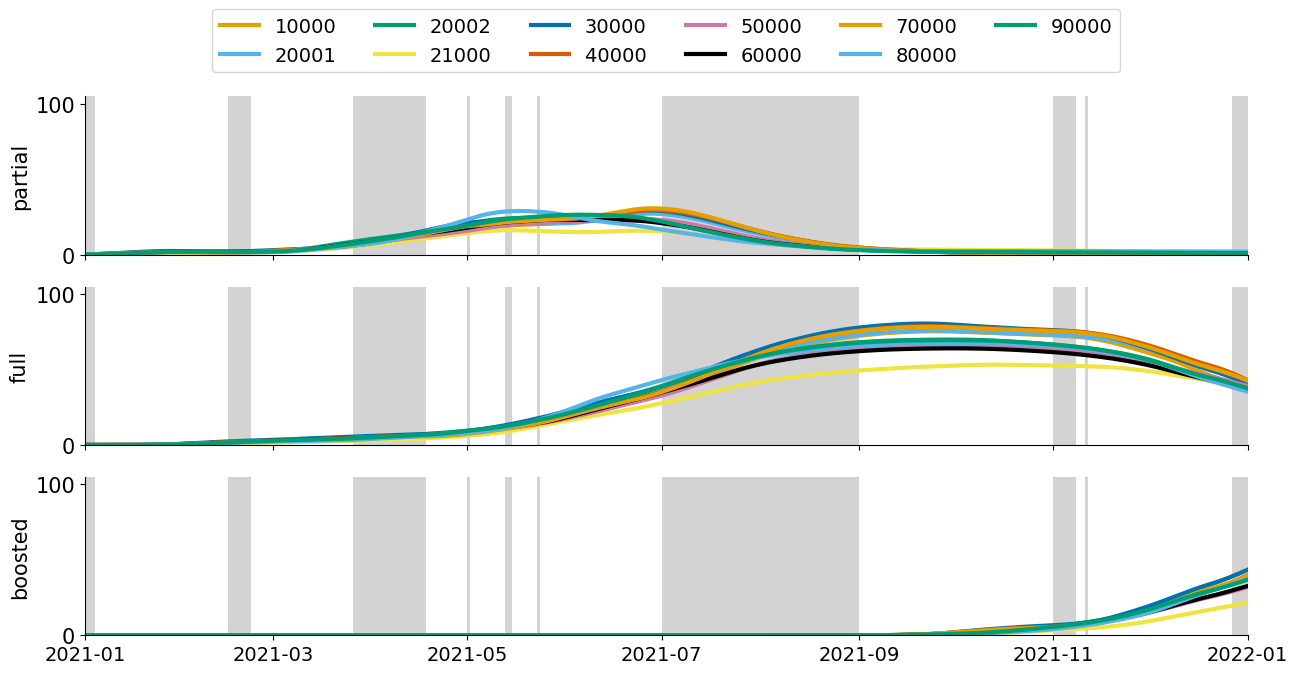

In [37]:
x_model = out['date'].values
y_model = out['S'].mean(dim='draws').sum(dim=['age_groups'])+out['E'].mean(dim='draws').sum(dim=['age_groups'])+out['I'].mean(dim='draws').sum(dim=['age_groups'])+out['A'].mean(dim='draws').sum(dim=['age_groups'])+out['R'].mean(dim='draws').sum(dim=['age_groups'])

fig, axs = plt.subplots(3, 1, figsize=(15,7), sharex=True)

############################
## Vaccination parameters ##
############################

from covid19_DTM.data.utils import construct_initN
initN=construct_initN(age_classes=age_classes, agg='prov')
for NIS in df.index.get_level_values('NIS').unique():
    axs[0].plot(x_model, y_model.sel(NIS=NIS).sel(doses='partial')/np.sum(initN.loc[NIS,:])*100)
    axs[1].plot(x_model, y_model.sel(NIS=NIS).sel(doses='full')/np.sum(initN.loc[NIS,:])*100)
    axs[2].plot(x_model, y_model.sel(NIS=NIS).sel(doses='boosted')/np.sum(initN.loc[NIS,:])*100)

################
## Background ##
################

start_background = pd.Timestamp(2020, 1, 1)
week_color='white'#'white'
weekend_color='white'#'lightgrey'
vacation_color='lightgrey'#weekend_color
for i in range(3):
    color_timeframes(start_background, pd.Timestamp(2022, 1, 1), ax=axs[i], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
    
##################
## Format ticks ##
##################

ticklabelsize=14
xticks=[pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 3, 1).date(), \
        pd.Timestamp(2021, 5, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
        pd.Timestamp(2021, 9, 1).date(), pd.Timestamp(2021, 11, 1).date(),
        pd.Timestamp(2022, 1, 1).date()]

import matplotlib.dates as mdates

# Grids, ticks, etc.
ylabels=['partial', 'full', 'boosted',]
for i in range(3):
    axs[i].set_ylabel(ylabels[i])
    axs[i].set_yticks([0,100])
    axs[i].set_ylim([0,105])
    axs[i].set_title(None)
    axs[i].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
    axs[i].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
    axs[i].set_xlim([pd.Timestamp(2021, 1, 1), pd.Timestamp(2022, 1, 1)])
    axs[i].set_xlabel(None)
    axs[i].grid(False)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

axs[0].legend(df.index.get_level_values('NIS').unique(), loc='center', bbox_to_anchor=(0.5, 1.35), ncol=6, fontsize=ticklabelsize) 
    
plt.savefig("vaccination_timeseries_NIS.pdf", bbox_inches='tight')

## Sizes of vaccinated populations (age stratified)

/tmp/ipykernel_134504/2584039282.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[i].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')


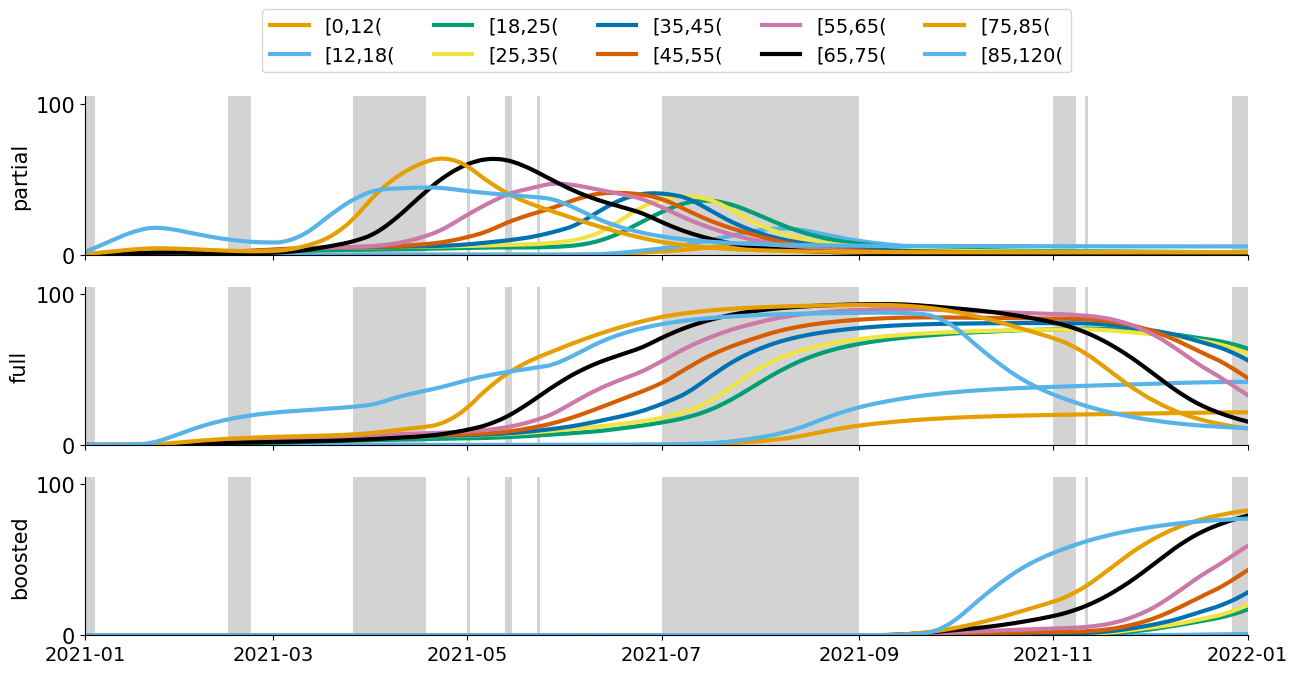

In [38]:
x_model = out['date'].values
y_model = out['S'].sum(dim=['NIS']).mean(dim='draws') + \
            out['R'].sum(dim=['NIS']).mean(dim='draws')
            #out['E'].mean(dim='draws').sum(dim=['NIS'])+ \
            #out['I'].mean(dim='draws').sum(dim=['NIS'])+ \
            #out['A'].mean(dim='draws').sum(dim=['NIS'])+ \
            

fig, axs = plt.subplots(3, 1, figsize=(15,7), sharex=True)

############################
## Vaccination parameters ##
############################

cm = plt.get_cmap('gist_rainbow')

from covid19_DTM.data.utils import construct_initN
initN=construct_initN(age_classes=age_classes)
for idx,age_class in enumerate(df.index.get_level_values('age').unique()):
    axs[0].plot(x_model, y_model.sel(age_groups=age_class).sel(doses='partial')/np.sum(initN.iloc[idx])*100)
    axs[1].plot(x_model, y_model.sel(age_groups=age_class).sel(doses='full')/np.sum(initN.iloc[idx])*100)
    axs[2].plot(x_model, y_model.sel(age_groups=age_class).sel(doses='boosted')/np.sum(initN.iloc[idx])*100)

################
## Background ##
################

start_background = pd.Timestamp(2020, 1, 1)
week_color='white'
weekend_color='white'
vacation_color='lightgrey'
for i in range(3):
    color_timeframes(start_background, pd.Timestamp(2022, 1, 1), ax=axs[i], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)
    
##################
## Format ticks ##
##################

ticklabelsize=14
xticks=[pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 3, 1).date(), \
        pd.Timestamp(2021, 5, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
        pd.Timestamp(2021, 9, 1).date(), pd.Timestamp(2021, 11, 1).date(),
        pd.Timestamp(2022, 1, 1).date()]

import matplotlib.dates as mdates

# Grids, ticks, etc.
ylabels=['partial', 'full', 'boosted',]
for i in range(3):
    axs[i].set_ylabel(ylabels[i])
    axs[i].set_yticks([0,100])
    axs[i].set_ylim([0,105])
    axs[i].set_title(None)
    axs[i].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
    axs[i].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
    axs[i].set_xlim([pd.Timestamp(2021, 1, 1), pd.Timestamp(2022, 1, 1)])
    axs[i].set_xlabel(None)
    axs[i].grid(False)
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

legend_text=['[0,12(','[12,18(','[18,25(','[25,35(','[35,45(','[45,55(','[55,65(','[65,75(','[75,85(','[85,120(']
axs[0].legend(legend_text, loc='center', bbox_to_anchor=(0.5, 1.35), ncol=5, fontsize=ticklabelsize) 
    
plt.savefig("vaccination_timeseries_age.pdf", bbox_inches='tight')

## Plot national and regional daily new hospitalisations

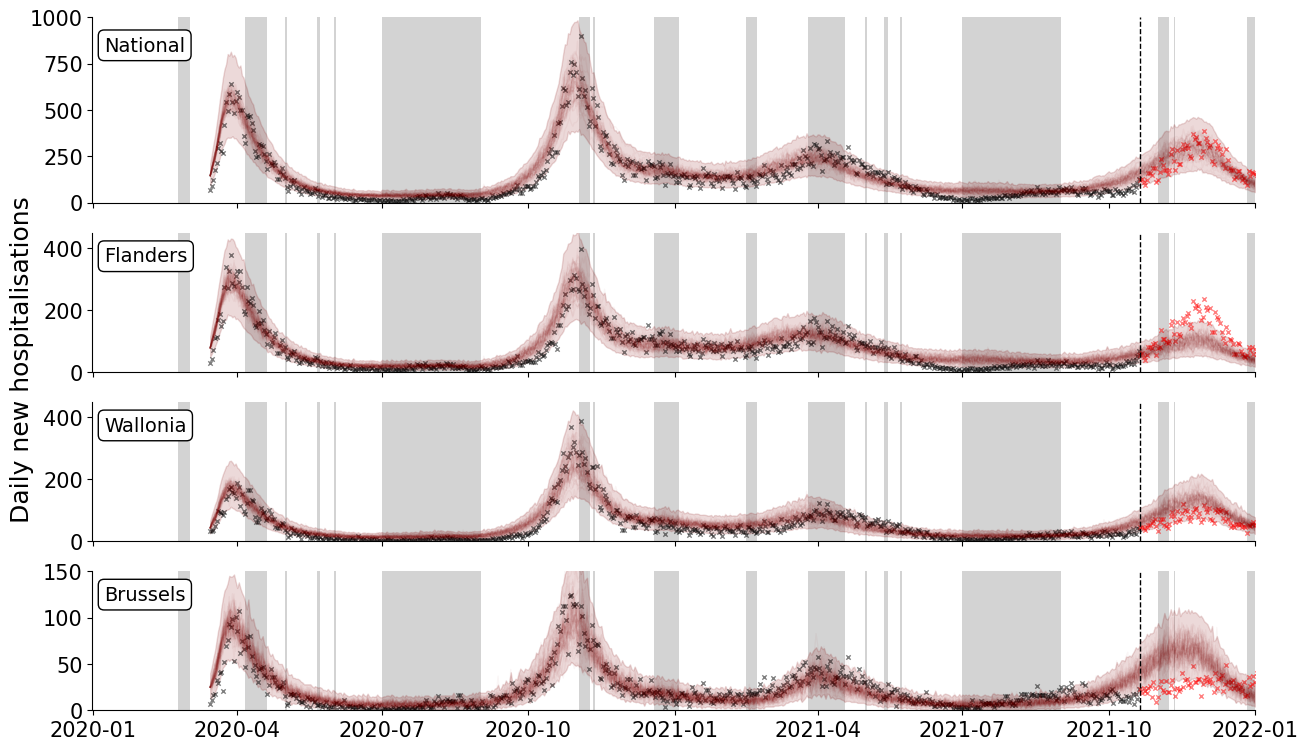

In [39]:
fig, axs = plt.subplots(4,1, figsize=(15,9), gridspec_kw={'height_ratios': [2, 1.5, 1.5, 1.5]}, sharex=True)

###############
## Get dates ##
###############

x_model = out.date.values
x_data = public_spatial_hosp_df.index.get_level_values('date').unique()

#######################
## Figure properties ##
#######################

# Scatter properties
color_cal = 'k'
color_future = 'r'
scatter_size = 10
# Compute scatter attributes
idx_first_cal = [idx for idx, date in enumerate(x_data) if date >= pd.Timestamp(samples_dict['start_calibration'])][0]
idx_final_cal = [idx for idx, date in enumerate(x_data) if date <= pd.Timestamp(samples_dict['end_calibration'])][-1]

# Model prediction properties
linewidth=1

################
## Background ##
################

start_background = pd.Timestamp(2020, 1, 1)
week_color='white'#'white'
weekend_color='white'#'lightgrey'
vacation_color='lightgrey'#weekend_color
for i in range(4):
    color_timeframes(start_background, end_sim, ax=axs[i], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

##############
## National ##
##############

# Aggregate data
y_model = out['H_in'].sum(dim=['NIS','age_groups','doses']).values
y_data = public_spatial_hosp_df.groupby(by='date').sum()
# Add negative binomial noise
mean, median, lower, upper = add_negative_binomial(y_model, dispersion, K, add_to_mean=False)
# Plot model prediction
for i in range(N):
    axs[0].plot(x_model, y_model[i,:], color='maroon', linewidth=linewidth, alpha=alpha_structural)
axs[0].fill_between(x_model, lower, upper, alpha=alpha_statistical, color='maroon')
# Scatter data
axs[0].scatter(x_data[idx_first_cal:idx_final_cal], y_data[idx_first_cal:idx_final_cal], \
               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=alpha_scatter)
axs[0].scatter(x_data[idx_final_cal:], y_data[idx_final_cal:], \
               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=alpha_scatter)

############## 
## Regional ##
##############

i = 1
for NIS_list in [[10000, 20001, 40000, 30000, 70000], [20002, 50000, 60000, 80000, 90000], [21000,]]:
    
    # Aggregate data
    y_model = 0
    y_data = 0
    for NIS in NIS_list:
        y_model += out['H_in'].sel(NIS=NIS).sum(dim=['age_groups', 'doses']).values
        y_data += public_spatial_hosp_df.loc[slice(None), NIS].values

    # Add negative binomial noise
    mean, median, lower, upper = add_negative_binomial(y_model, dispersion, K, add_to_mean=False)
    # Plot model prediction
    for j in range(N):
        axs[i].plot(x_model, y_model[j,:], color='maroon', linewidth=linewidth, alpha=alpha_structural)
    axs[i].fill_between(x_model, lower, upper, alpha=alpha_statistical, color='maroon')
    # Scatter data
    axs[i].scatter(x_data[idx_first_cal:idx_final_cal], y_data[idx_first_cal:idx_final_cal], \
               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=alpha_scatter)
    axs[i].scatter(x_data[idx_final_cal:], y_data[idx_final_cal:], \
               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=alpha_scatter)
    i+=1
    
##################
## Format ticks ##
##################

ticklabelsize=12
xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 7, 1).date(), \
        pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
        pd.Timestamp(2022, 1, 1).date()]

#################
## Format axes ##
#################

# Limits
axs[0].set_ylim([0, 1000])
axs[1].set_ylim([0, 450])
axs[2].set_ylim([0, 450])
axs[3].set_ylim([0, 150])

# Grids, ticks, etc.
for i in range(4):
    axs[i].set_title(None)
    #axs[i].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
    #axs[i].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
    axs[i].set_xlim([pd.Timestamp(2020, 1, 1), pd.Timestamp(2022, 1, 1)])
    axs[i].set_xlabel(None)
    axs[i].grid(False)
    axs[i].axvline(pd.Timestamp(samples_dict['end_calibration']), linestyle='--', color='k', linewidth=1)

# Ylabel
fig.supylabel('Daily new hospitalisations', x=0.07)

##############
## Text box ##
##############

titles = ['National', 'Flanders', 'Wallonia', 'Brussels']   
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)

for i in range(4):
    # place a text box in upper left in axes coords
    axs[i].text(0.01, 0.90, titles[i], transform=axs[i].transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

plt.savefig("national-and-regional-complete-model-fit.pdf", bbox_inches='tight')

## Plot provincial daily new hospitalisations (appendix)

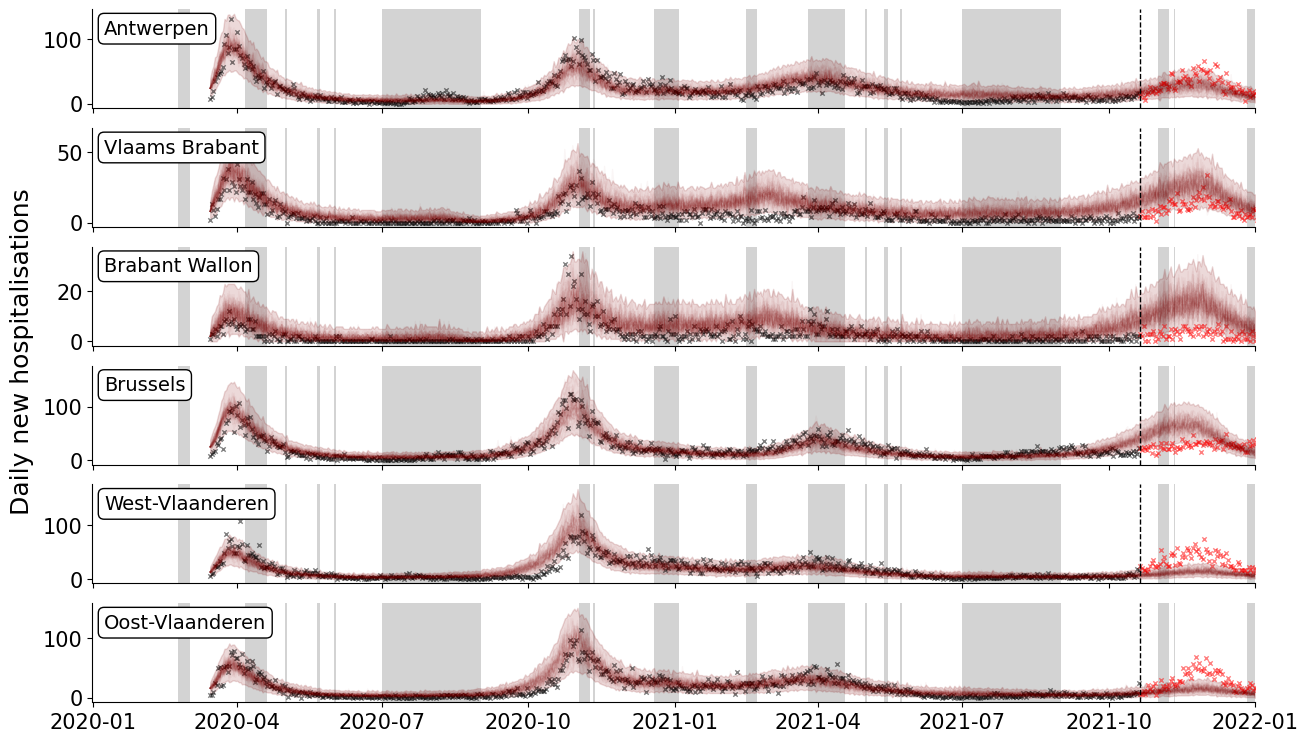

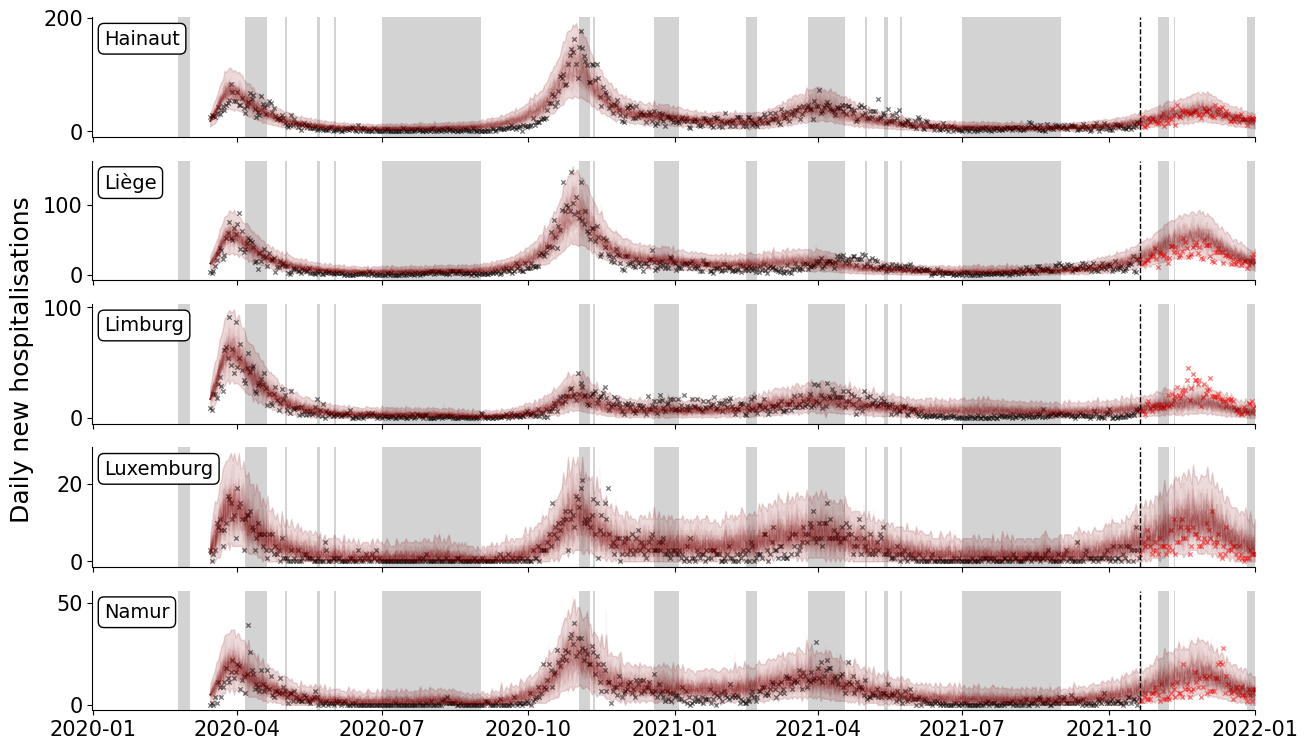

In [40]:
NIS_superlist = [df.index.get_level_values('NIS').unique()[:6], df.index.get_level_values('NIS').unique()[6:]]
titles_superlist = [['Antwerpen', 'Vlaams Brabant', 'Brabant Wallon', 'Brussels', 'West-Vlaanderen', 'Oost-Vlaanderen'],
                    ['Hainaut','Liège','Limburg','Luxemburg','Namur']]

for idx,NIS_list in enumerate(NIS_superlist):
    titles_list = titles_superlist[idx]

    fig, axs = plt.subplots(len(NIS_list),1, figsize=(15,9), sharex=True)

    ###############
    ## Get dates ##
    ###############

    x_model = out.date.values
    x_data = public_spatial_hosp_df.index.get_level_values('date').unique()

    #######################
    ## Figure properties ##
    #######################

    # Scatter properties
    color_cal = 'k'
    color_future = 'r'
    scatter_size = 10
    # Compute scatter attributes
    idx_first_cal = [idx for idx, date in enumerate(x_data) if date >= pd.Timestamp(samples_dict['start_calibration'])][0]
    idx_final_cal = [idx for idx, date in enumerate(x_data) if date <= pd.Timestamp(samples_dict['end_calibration'])][-1]

    # Model prediction properties
    linewidth=1

    ################
    ## Background ##
    ################

    start_background = pd.Timestamp(2020, 1, 1)
    week_color='white'#'white'
    weekend_color='white'#'lightgrey'
    vacation_color='lightgrey'#weekend_color
    for i in range(len(NIS_list)):
        color_timeframes(start_background, end_sim, ax=axs[i], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

    #####################
    ## Provincial data ##
    #####################

    for i, NIS in enumerate(NIS_list):
        # Get data
        y_model = out['H_in'].sel(NIS=NIS).sum(dim=['age_groups','doses']).values
        y_data = public_spatial_hosp_df.loc[slice(None), NIS].values
        # Add negative binomial noise
        mean, median, lower, upper = add_negative_binomial(y_model, dispersion, K, add_to_mean=False)
        # Plot model prediction
        for j in range(N):
            axs[i].plot(x_model, y_model[j,:], color='maroon', linewidth=linewidth, alpha=alpha_structural)
        axs[i].fill_between(x_model, lower, upper, alpha=alpha_statistical, color='maroon')
        # Scatter data
        axs[i].scatter(x_data[idx_first_cal:idx_final_cal], y_data[idx_first_cal:idx_final_cal], \
                   s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=alpha_scatter)
        axs[i].scatter(x_data[idx_final_cal:], y_data[idx_final_cal:], \
                   s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=alpha_scatter)

    ##################
    ## Format ticks ##
    ##################

    ticklabelsize=12
    xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 7, 1).date(), \
            pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
            pd.Timestamp(2022, 1, 1).date()]

    #################
    ## Format axes ##
    #################

    # Grids, ticks, etc.
    for i in range(len(NIS_list)):
        axs[i].set_title(None)
        #axs[i].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
        #axs[i].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
        axs[i].set_xlim([pd.Timestamp(2020, 1, 1), pd.Timestamp(2022, 1, 1)])
        axs[i].set_xlabel(None)
        axs[i].grid(False)
        axs[i].axvline(pd.Timestamp(samples_dict['end_calibration']), linestyle='--', color='k', linewidth=1)

    # Ylabel
    fig.supylabel('Daily new hospitalisations', x=0.07)

    ##############
    ## Text box ##
    ##############

    # these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='white', alpha=1)

    for i in range(len(NIS_list)):
        # place a text box in upper left in axes coords
        axs[i].text(0.01, 0.90, titles_list[i], transform=axs[i].transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
        
    plt.savefig("provincial-complete-model-fit-"+str(idx)+".pdf", bbox_inches='tight')
    
    plt.show()
    plt.close()

## Plot RMSE with vs. without mobility

In [41]:
from scipy.special import gammaln
def ll_negative_binomial(ymodel, ydata, alpha):
    return ydata*np.log(ymodel) - (ydata + 1/alpha)*np.log(1+alpha*ymodel) + ydata*np.log(alpha) + gammaln(ydata+1/alpha) - gammaln(ydata+1) - len(ydata)*gammaln(1/alpha)

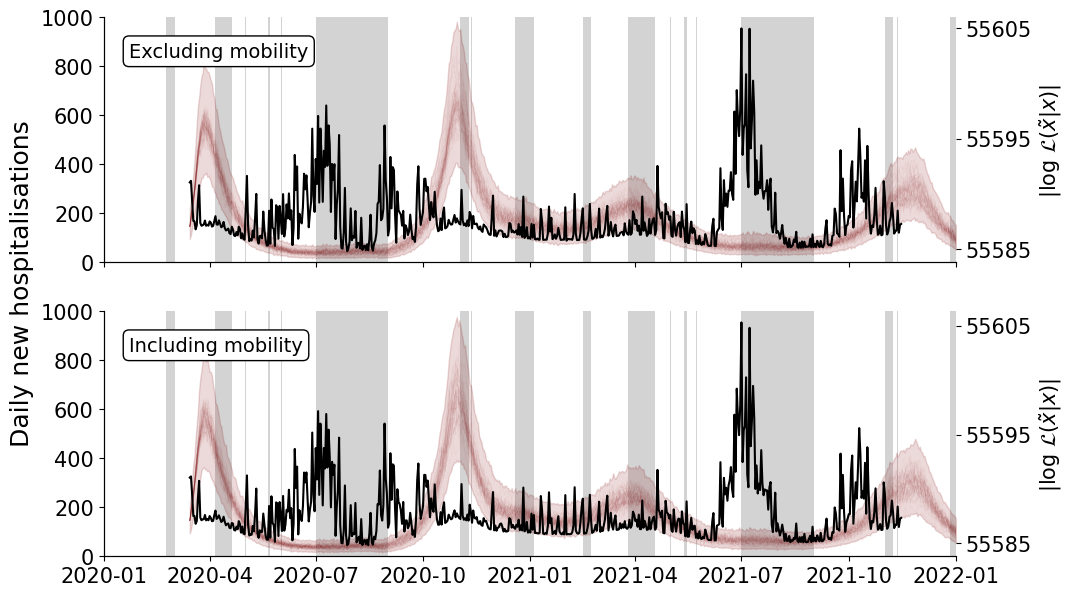

In [47]:
ticks=[55585, 55595, 55605]

fig, axs = plt.subplots(2,1, figsize=(11,7), sharex=True)
linewidth=0.5

######################
## Without mobility ##
######################

# Background
start_background = pd.Timestamp(2020, 1, 1)
week_color='white'#'white'
weekend_color='white'#'lightgrey'
vacation_color='lightgrey'#weekend_color
color_timeframes(start_background, end_sim, ax=axs[0], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# Plot model prediction
x_model = out_no_mobility.date.values
y_model = out_no_mobility['H_in'].sum(dim=['NIS', 'age_groups', 'doses']).values
y_data = public_spatial_hosp_df.groupby(by='date').sum()
# Add negative binomial noise
mean, median, lower, upper = add_negative_binomial(y_model, dispersion, K, add_to_mean=False)
# Plot model prediction
for i in range(N):
    axs[0].plot(x_model, y_model[i,:], color='maroon', linewidth=linewidth, alpha=alpha_structural)
axs[0].fill_between(x_model, lower, upper, alpha=alpha_statistical, color='maroon')
# Scatter data
#axs[0].scatter(x_data[idx_first_cal:idx_final_cal], y_data[idx_first_cal:idx_final_cal], \
#               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=alpha_scatter/2)
#axs[0].scatter(x_data[idx_final_cal:], y_data[idx_final_cal:], \
#               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=alpha_scatter/2)

# Compute NRMSE
model = out_no_mobility['H_in'].sum(dim=['NIS','age_groups','doses']).mean(dim='draws').to_series()
data = y_data[start_calibration:end_calibration]
#NRMSE_no_mobility = np.sqrt( ((model - data)/data)**2)
NRMSE_no_mobility = np.abs(ll_negative_binomial(model, data, 0.028))

# Plot NRMSE
ax2 = axs[0].twinx()
ax2.plot(NRMSE_no_mobility, color='black', linewidth=1.5)
ax2.grid(False)
ax2.set_ylabel('|log $\mathcal{L}( \\tilde{x}|x)|$')
ax2.set_yticks(ticks=ticks, rotation=0, size=ticklabelsize, ha='center')

# Format ticks
ticklabelsize=12
xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 4, 1).date(), \
        pd.Timestamp(2020, 7, 1).date(), pd.Timestamp(2020, 10, 1).date(), \
        pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 4, 1).date(), \
        pd.Timestamp(2021, 7, 1).date(), pd.Timestamp(2021, 10, 1).date(), pd.Timestamp(2022, 1, 1).date()]

# Grids, ticks, etc.
axs[0].set_title(None)
#axs[0].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
#axs[0].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
axs[0].set_xlim([pd.Timestamp(2020, 1, 1), pd.Timestamp(2022, 1, 1)])
axs[0].set_xlabel(None)
axs[0].grid(False)
#axs[0].axvline(pd.Timestamp(samples_dict['end_calibration']), linestyle='--', color='k', linewidth=1)
axs[0].set_ylim([0,1000])

# Ylabel
fig.supylabel('Daily new hospitalisations', x=0.07)

# Textbox
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
axs[0].text(0.03, 0.90, 'Excluding mobility', transform=axs[0].transAxes, fontsize=14,
    verticalalignment='top', bbox=props)

################################
## Spatial model national fit ##
################################

# Background 
start_background = pd.Timestamp(2020, 1, 1)
week_color='white'#'white'
weekend_color='white'#'lightgrey'
vacation_color='lightgrey'#weekend_color
color_timeframes(start_background, end_sim, ax=axs[1], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# Aggregate data
x_model = out.date.values
y_model = out['H_in'].sum(dim=['NIS', 'age_groups', 'doses']).values
y_data = public_spatial_hosp_df.groupby(by='date').sum()
# Add negative binomial noise
mean, median, lower, upper = add_negative_binomial(y_model, dispersion, K, add_to_mean=False)
# Plot model prediction
for i in range(N):
    axs[1].plot(x_model, y_model[i,:], color='maroon', linewidth=linewidth, alpha=alpha_structural)
axs[1].fill_between(x_model, lower, upper, alpha=alpha_statistical, color='maroon')
# Scatter data
#axs[1].scatter(x_data[idx_first_cal:idx_final_cal], y_data[idx_first_cal:idx_final_cal], \
#               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=alpha_scatter/2)
#axs[1].scatter(x_data[idx_final_cal:], y_data[idx_final_cal:], \
#               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=alpha_scatter/2)

# Compute NRMSE
model = out['H_in'].sum(dim=['NIS','age_groups','doses']).mean(dim='draws').to_series()
data = y_data[start_calibration:end_calibration]
NRMSE_spatial = np.sqrt( ((model - data)/data)**2)
NRMSE_spatial = np.abs(ll_negative_binomial(model, data, 0.028))

# Plot NRMSE
ax2 = axs[1].twinx()
ax2.plot(NRMSE_spatial, color='black', linewidth=1.5)
ax2.grid(False)
ax2.set_ylabel('|log $\mathcal{L}( \\tilde{x}|x)|$')
ax2.set_yticks(ticks=ticks, rotation=0, size=ticklabelsize, ha='center')

# Format ticks
ticklabelsize=14
xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 4, 1).date(), \
        pd.Timestamp(2020, 7, 1).date(), pd.Timestamp(2020, 10, 1).date(), \
        pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 4, 1).date(), \
        pd.Timestamp(2021, 7, 1).date(), pd.Timestamp(2021, 10, 1).date(), pd.Timestamp(2022, 1, 1).date()]

# Grids, ticks, etc.
axs[1].set_title(None)
#axs[1].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
#axs[1].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
axs[1].set_xlim([pd.Timestamp(2020, 1, 1), pd.Timestamp(2022, 1, 1)])
axs[1].set_xlabel(None)
axs[1].grid(False)
#axs[1].axvline(pd.Timestamp(samples_dict['end_calibration']), linestyle='--', color='k', linewidth=1)
axs[1].set_ylim([0,1000])

# Ylabel
fig.supylabel('Daily new hospitalisations', x=0.04)

# Textbox
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
axs[1].text(0.03, 0.90, 'Including mobility', transform=axs[1].transAxes, fontsize=14,
    verticalalignment='top', bbox=props)

plt.savefig("RMSE-mobility.pdf", bbox_inches='tight')
plt.show()
plt.close()

0.6597658667755223


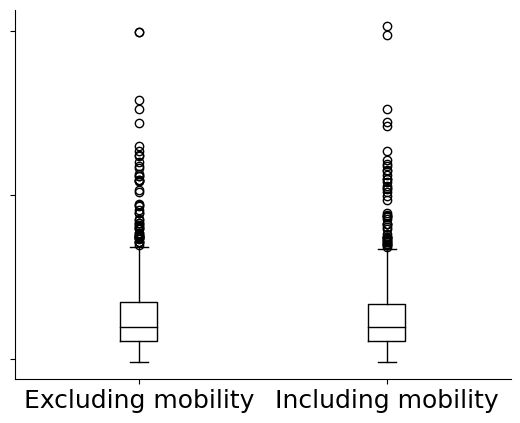

In [48]:
#############
## Boxplot ##
#############

from scipy.stats import mannwhitneyu

# Difference in ICU residence time in case of recovery and death
x = NRMSE_no_mobility.dropna().values
y = NRMSE_spatial.dropna().values
stat, p_mwu = mannwhitneyu(x, y)
print(p_mwu)

fig,ax=plt.subplots()
bp = ax.boxplot([x, y], positions=[1,2])
plt.setp(bp['medians'], color='k')

ax.set_xticklabels(['Excluding mobility'.format(np.mean(x)),
                    'Including mobility'.format(np.mean(y))], size=18)

#ax.set_ylabel('RMSE (-)')
#ax.set_ylim(0,8.5)

# Textbox
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
#ax.text(0.03, 1.2, 'Mann-Whitney U test\np-value: {:.2f}'.format(p_mwu), transform=ax.transAxes, fontsize=14,
#    verticalalignment='top', bbox=props)

ax.grid(False)


#plt.yscale('symlog', linthresh=0.1)
ax.set_yticks(ticks)
ax.set_yticklabels([])

plt.savefig("RMSE-mobility-boxplot.pdf", bbox_inches='tight')
plt.show()

## Plot RMSE national vs. spatial

In [40]:
######################################
## Load national samples dictionary ##
######################################

# Path where MCMC samples were saved
samples_path = '../../../data/covid19_DTM/interim/model_parameters/calibrations/national/'
filename = 'national_REF_SAMPLES_2023-02-23.json'
# Load samples dict
from covid19_DTM.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+str(filename), age_stratification_size=age_stratification_size)
dispersion = float(samples_dict['dispersion'])
# Start of calibration warmup and beta
start_calibration = samples_dict['start_calibration']
# Last datapoint used to calibrate warmup and beta
end_calibration_national = samples_dict['end_calibration']
# Warmup
warmup = samples_dict['warmup']

###############################
## Initialize national model ##
###############################

from covid19_DTM.models.utils import initialize_COVID19_SEIQRD_hybrid_vacc
national_model, BASE_samples_dict, initN = initialize_COVID19_SEIQRD_hybrid_vacc(age_stratification_size=age_stratification_size,
                                                                                 start_date=start_calibration, update_data=False,
                                                                                 stochastic=True)

#######################
## Sampling function ##
#######################

from covid19_DTM.models.draw_functions import draw_fnc_COVID19_SEIQRD_hybrid_vacc as draw_fnc

In [41]:
####################
## Simulate model ##
####################

print('\n1) Simulating national COVID-19 SEIRD '+str(N)+' times')
out_national = national_model.sim([start_calibration, end_sim], tau=0.75,
                            N=N, draw_function=draw_fnc, processes=processes, samples=samples_dict)


1) Simulating national COVID-19 SEIRD 90 times


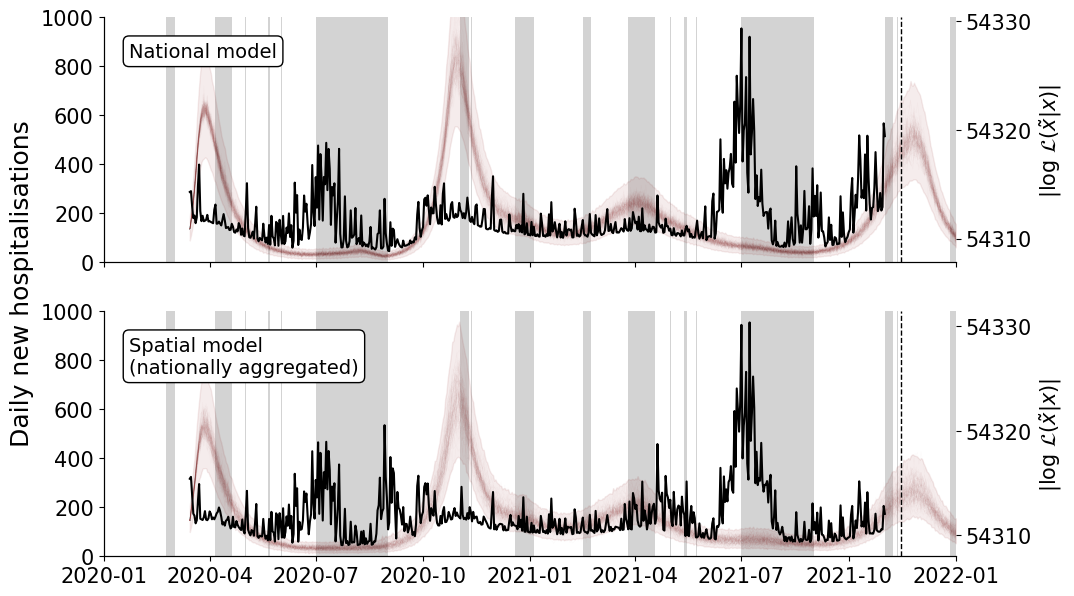

In [42]:
fig, axs = plt.subplots(2,1, figsize=(11,7), sharex=True)
linewidth=0.5
########################
## National model fit ##
########################

# Background
start_background = pd.Timestamp(2020, 1, 1)
week_color='white'#'white'
weekend_color='white'#'lightgrey'
vacation_color='lightgrey'#weekend_color
color_timeframes(start_background, end_sim, ax=axs[0], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# Plot model prediction
x_model = out_national.date.values
y_model = out_national['H_in'].sum(dim=['age_groups','doses']).values
y_data = public_spatial_hosp_df.groupby(by='date').sum()
# Add negative binomial noise
mean, median, lower, upper = add_negative_binomial(y_model, dispersion, K, add_to_mean=False)
# Plot model prediction
for i in range(N):
    axs[0].plot(x_model, y_model[i,:], color='maroon', linewidth=linewidth, alpha=alpha_structural/1.5)
axs[0].fill_between(x_model, lower, upper, alpha=alpha_statistical/2, color='maroon')
# Scatter data
#axs[0].scatter(x_data[idx_first_cal:idx_final_cal], y_data[idx_first_cal:idx_final_cal], \
#               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=alpha_scatter/2)
#axs[0].scatter(x_data[idx_final_cal:], y_data[idx_final_cal:], \
#               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=alpha_scatter/2)

# Compute NRMSE
model = out_national['H_in'].sum(dim=['age_groups','doses']).mean(dim='draws').to_series()
data = y_data[start_calibration:end_calibration]
#NRMSE_national = np.sqrt( ((model - data)/data)**2)
NRMSE_national = np.abs(ll_negative_binomial(model, data, 0.028))


# Plot NRMSE
ax2 = axs[0].twinx()
ax2.plot(NRMSE_national, color='black', linewidth=1.5)
ax2.grid(False)
ax2.set_ylabel('|log $\mathcal{L}( \\tilde{x}|x)|$')
#ax2.set_ylim([0,7])
ax2.set_yticks(ticks=[54310, 54320, 54330], rotation=0, size=ticklabelsize, ha='center')

# Format ticks
ticklabelsize=14
xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 7, 1).date(), \
        pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
        pd.Timestamp(2022, 1, 1).date()]

# Grids, ticks, etc.
axs[0].set_title(None)
#axs[0].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
#axs[0].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
axs[0].set_xlim([pd.Timestamp(2020, 1, 1), pd.Timestamp(2022, 1, 1)])
axs[0].set_xlabel(None)
axs[0].grid(False)
axs[0].axvline(pd.Timestamp(samples_dict['end_calibration']), linestyle='--', color='k', linewidth=1)
axs[0].set_ylim([0,1000])

# Ylabel
fig.supylabel('Daily new hospitalisations', x=0.07)

# Textbox
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
axs[0].text(0.03, 0.90, 'National model', transform=axs[0].transAxes, fontsize=14,
    verticalalignment='top', bbox=props)

################################
## Spatial model national fit ##
################################

# Background 
start_background = pd.Timestamp(2020, 1, 1)
week_color='white'
weekend_color='white'
vacation_color='lightgrey'
color_timeframes(start_background, end_sim, ax=axs[1], week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

# Aggregate data
x_model = out.date.values
y_model = out['H_in'].sum(dim=['NIS', 'age_groups', 'doses']).values
y_data = public_spatial_hosp_df.groupby(by='date').sum()
# Add negative binomial noise
mean, median, lower, upper = add_negative_binomial(y_model, dispersion, K, add_to_mean=False)
# Plot model prediction
for i in range(N):
    axs[1].plot(x_model, y_model[i,:], color='maroon', linewidth=linewidth, alpha=alpha_structural/1.5)
axs[1].fill_between(x_model, lower, upper, alpha=alpha_statistical/2, color='maroon')
# Scatter data
#axs[1].scatter(x_data[idx_first_cal:idx_final_cal], y_data[idx_first_cal:idx_final_cal], \
#               s=scatter_size, color=color_cal, marker='x', linewidth=1, alpha=alpha_scatter/2)
#axs[1].scatter(x_data[idx_final_cal:], y_data[idx_final_cal:], \
#               s=scatter_size, color=color_future, marker='x', linewidth=1, alpha=alpha_scatter/2)

# Compute NRMSE
model = out['H_in'].sum(dim=['NIS','age_groups','doses']).mean(dim='draws').to_series()
data = y_data[start_calibration:end_calibration]
#NRMSE_spatial = np.sqrt( ((model - data)/data)**2)
NRMSE_spatial = np.abs(ll_negative_binomial(model, data, 0.028))
# Plot NRMSE
ax2 = axs[1].twinx()
ax2.plot(NRMSE_spatial, color='black', linewidth=1.5)
ax2.grid(False)
ax2.set_ylabel('|log $\mathcal{L}( \\tilde{x}|x)|$')
#ax2.set_ylim([0,7])
ax2.set_yticks(ticks=[54310, 54320, 54330], rotation=0, size=ticklabelsize, ha='center')

# Format ticks
ticklabelsize=14
xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 7, 1).date(), \
        pd.Timestamp(2021, 1, 1).date(), pd.Timestamp(2021, 7, 1).date(), \
        pd.Timestamp(2022, 1, 1).date()]

# Grids, ticks, etc.
axs[1].set_title(None)
#axs[1].set_xticklabels(xticks, rotation=0, size=ticklabelsize, ha='center')
#axs[1].set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
axs[1].set_xlim([pd.Timestamp(2020, 1, 1), pd.Timestamp(2022, 1, 1)])
axs[1].set_xlabel(None)
axs[1].grid(False)
axs[1].axvline(pd.Timestamp(samples_dict['end_calibration']), linestyle='--', color='k', linewidth=1)
axs[1].set_ylim([0,1000])

# Ylabel
fig.supylabel('Daily new hospitalisations', x=0.04)

# Textbox
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
axs[1].text(0.03, 0.90, 'Spatial model\n(nationally aggregated)', transform=axs[1].transAxes, fontsize=14,
    verticalalignment='top', bbox=props)

plt.savefig("RMSE-model-fit.pdf", bbox_inches='tight')
plt.show()
plt.close()

0.5341180153802749


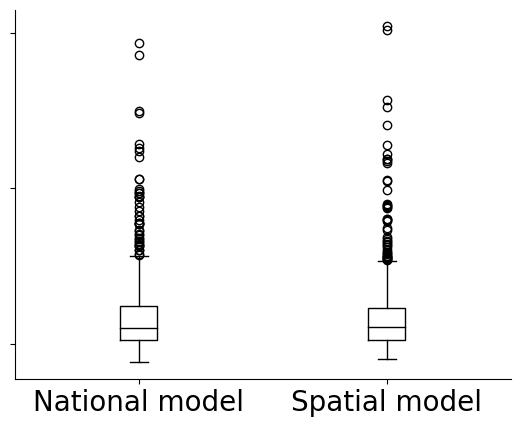

In [43]:
#############
## Boxplot ##
#############
from scipy.stats import mannwhitneyu

# Difference in ICU residence time in case of recovery and death
x = NRMSE_national.dropna().values
y = NRMSE_spatial.dropna().values
stat, p_mwu = mannwhitneyu(x, y)
print(p_mwu)

fig,ax=plt.subplots()
bp = ax.boxplot([x, y], positions=[1,2])
plt.setp(bp['medians'], color='k')

ax.set_xticklabels(['National model'.format(np.mean(x)),
                    'Spatial model'.format(np.mean(y))], size=20)


#ax.set_ylabel('RMSE (-)')
#ax.set_ylim(0,8.5)

# Textbox
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
#ax.text(0.03, 1.2, 'Mann-Whitney U test\np-value: {:.2f}'.format(p_mwu), transform=ax.transAxes, fontsize=14,
#    verticalalignment='top', bbox=props)

ax.grid(False)

#plt.yscale('symlog', linthresh=0.1)
ax.set_yticks([54310, 54320, 54330])
ax.set_yticklabels([])


plt.savefig("RMSE-model-fit-boxplot.pdf", bbox_inches='tight')
plt.show()

## Plot recovered compartment and seroprevalence data

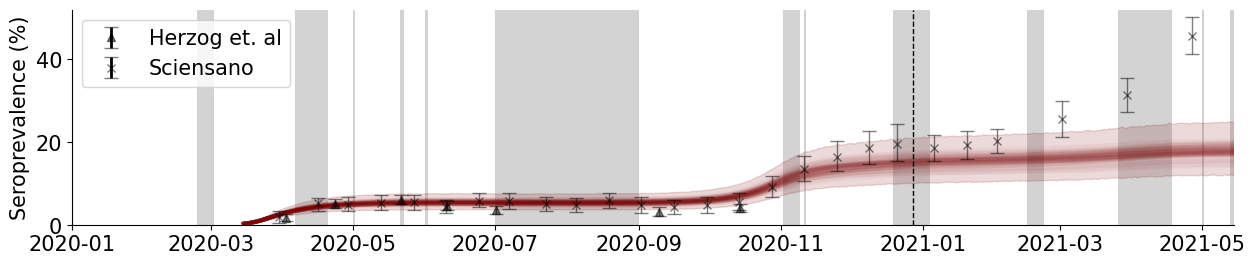

In [55]:
fig, ax = plt.subplots(figsize=(15,2.8))

linewidth = 3

################
## Background ##
################

start_background = pd.Timestamp(2020, 1, 1)
week_color='white'
weekend_color='white'
vacation_color='lightgrey'
color_timeframes(start_background, end_sim, ax=ax, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

##############################
## Simulated seroprevalence ##
##############################

# Total number of individuals
n_individuals = initN.sum()
# Get data
y_model = out['R'].sum(dim=['NIS','doses','age_groups']).values
# Add negative binomial noise
mean, median, lower, upper = add_negative_binomial(y_model, dispersion, K, add_to_mean=False)
# Get the dates
x_model = out.date.values
# Plot fraction of immunes with uncertainty
for i in range(N):
    ax.plot(x_model, y_model[i,:]/n_individuals*100, color='maroon', linewidth=linewidth, alpha=alpha_structural)
ax.fill_between(x_model, lower/n_individuals*100, upper/n_individuals*100, alpha=alpha_statistical, color='maroon')

#########################
## Seroprevalence data ##
#########################

yerr = np.array([df_sero_herzog['rel','mean']*100 - df_sero_herzog['rel','LL']*100, df_sero_herzog['rel','UL']*100 - df_sero_herzog['rel','mean']*100 ])
ax.errorbar(x=df_sero_herzog.index,y=df_sero_herzog['rel','mean'].values*100,yerr=yerr, alpha=alpha_scatter, fmt='^', color='black', elinewidth=1, capsize=5, label='Herzog et. al')
yerr = np.array([df_sero_sciensano['rel','mean'][:27]*100 - df_sero_sciensano['rel','LL'][:27]*100, df_sero_sciensano['rel','UL'][:27]*100 - df_sero_sciensano['rel','mean'][:27]*100 ])
ax.errorbar(x=df_sero_sciensano[:27].index,y=df_sero_sciensano['rel','mean'][:27]*100,yerr=yerr, alpha=alpha_scatter, fmt='x', color='black', elinewidth=1, capsize=5, label='Sciensano')

#yerr = np.array([df_sero_sciensano['rel','mean'][16:]*100 - df_sero_sciensano['rel','LL'][16:]*100, df_sero_sciensano['rel','UL'][16:]*100 - df_sero_sciensano['rel','mean'][16:]*100 ])
#ax.errorbar(x=df_sero_sciensano[16:].index,y=df_sero_sciensano['rel','mean'][16:]*100,yerr=yerr, alpha=scatter_alpha, fmt='x', color='red', linewidth=1, capsize=5, label='Sciensano')

############
## Legend ##
############

leg = ax.legend(loc='upper left')
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh.set_linewidth(2)

#################
## Format axes ##
#################
    
ax.set_xlim([pd.Timestamp(2020, 1, 1), pd.Timestamp(2021, 5, 15)])
ax.set_ylim([0, 52])
ax.set_ylabel('Seroprevalence (%)')
ax.axvline(pd.Timestamp(2020, 12, 28), linestyle='--', color='k', linewidth=1)
ax.grid(False)

plt.savefig("seroprevalence-spatial-fit.pdf", bbox_inches='tight')